# Profiling skforecast

This document shows the profiling of the main classes, methods and functions available in skforecast. Understanding the are the bottle necks will help to:

+ Use it more efficiently
+ Improve the code for future releases


## Libraries

In [9]:
# Libraries
# ==============================================================================
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from lightgbm import LGBMRegressor

%load_ext pyinstrument

The pyinstrument extension is already loaded. To reload it, use:
  %reload_ext pyinstrument


## Data

A time series of length 1000 is created with random values.

In [11]:
# Data
# ==============================================================================
n = 1_000
data = pd.Series(data = np.random.normal(size=n))

## Dummy regressor

In order to isolate the training process of the regressor from the other parts of code, a dummy regressor class is created. This dummy regressor has a method fit that does nothing, and a predict method that returns a constant value.

In [12]:
class DummyRegressor(LinearRegression):
    '''
    Dummy regressor with dummy fit and predict methods.
    '''
    
    def fit(self, X, y):
        pass

    def predict(self, y):
        predictions = np.ones(shape = len(y))
        return predictions
        

## Profiling fit

In [13]:
%%pyinstrument

forecaster = ForecasterAutoreg(
                    regressor = DummyRegressor(),
                    lags      = 24
             )
forecaster.fit(y=data)

_     ._   __/__   _ _  _  _ _/_   Recorded: 10:57:48  Samples:  12
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.026     CPU time: 0.015
/   _/                      v4.3.0

Program: /home/ubuntu/anaconda3/envs/skforecast/lib/python3.8/site-packages/ipykernel_launcher.py --ip=127.0.0.1 --stdin=9008 --control=9006 --hb=9005 --Session.signature_scheme="hmac-sha256" --Session.key=b"388a5e00-9e44-4112-b6d2-a46f5cd02de3" --shell=9007 --transport="tcp" --iopub=9009 --f=/home/ubuntu/.local/share/jupyter/runtime/kernel-v2-1523iwvRASRRukbf.json

0.025 <module>  ../../../../../../tmp/ipykernel_12532/3559980462.py:2
`- 0.025 fit  skforecast/ForecasterAutoreg/ForecasterAutoreg.py:384
      [11 frames hidden]  skforecast, <built-in>, numpy, <__arr...
         0.024 _create_lags  skforecast/ForecasterAutoreg/ForecasterAutoreg.py:245
         |- 0.020 [self]

Almost the whole time spent by `fit` is required by the method `create_train_X_y`.

In [14]:
%%pyinstrument

forecaster = ForecasterAutoreg(
                    regressor = HistGradientBoostingRegressor(max_iter=10, random_state=123),
                    lags      = 24
             )

forecaster.fit(y=data)

_     ._   __/__   _ _  _  _ _/_   Recorded: 10:57:57  Samples:  441
 /_//_/// /_\ / //_// / //_'/ //     Duration: 23.691    CPU time: 91.215
/   _/                      v4.3.0

Program: /home/ubuntu/anaconda3/envs/skforecast/lib/python3.8/site-packages/ipykernel_launcher.py --ip=127.0.0.1 --stdin=9008 --control=9006 --hb=9005 --Session.signature_scheme="hmac-sha256" --Session.key=b"388a5e00-9e44-4112-b6d2-a46f5cd02de3" --shell=9007 --transport="tcp" --iopub=9009 --f=/home/ubuntu/.local/share/jupyter/runtime/kernel-v2-1523iwvRASRRukbf.json

23.690 <module>  ../../../../../../tmp/ipykernel_12532/1755484563.py:2
`- 23.690 fit  skforecast/ForecasterAutoreg/ForecasterAutoreg.py:384
      [118 frames hidden]  skforecast, sklearn, <built-in>, nump...
         8.609 Splitter.split_indices  <built-in>:0
         6.286 HistogramBuilder.compute_histograms_brute  <built-in>:0
         4.765 Splitter.find_node_split  <built-in>:0

When training a forecaster with a real machine learning regressor, the time spent by `create_train_X_y` is negligible compared to the time need by the `fit` method of the regressor. Therefore, improving the speed of `create_train_X_y` will not have much impact. 

## Profiling create_train_X_y

In order to understand how the method `create_train_X_y` is influenced by the length of the series and dumber of lags. 

In [32]:
# Profiling `create_train_X_y` for different length of series and number of lags
# ======================================================================================
series_length = np.geomspace(1000, 1000000, num=3, dtype=int)
n_lags = [5, 10, 50, 100, 200]
results = {}

for lags in n_lags:
    execution_time = []
    forecaster = ForecasterAutoreg(
                    regressor = DummyRegressor(),
                    lags      = lags
                 )

    for n in series_length:
        y = pd.Series(data = np.random.normal(size=n))
        tic = time.perf_counter()
        _ = forecaster.create_train_X_y(y=y)
        toc = time.perf_counter()
        execution_time.append(toc-tic)

    results[lags] = execution_time

results = pd.DataFrame(
            data =  results,
            index = series_length
        )

results

,5,10,50,100,200
1000,0.007866,0.006829,0.007682,0.007230,0.008554
31622,0.182192,0.184559,0.194497,0.202106,0.238556
1000000,5.583247,5.664639,6.139775,6.654017,8.237915


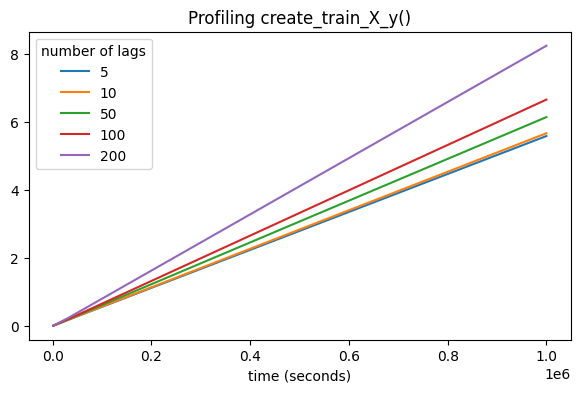

In [39]:
fig, ax = plt.subplots(figsize=(7, 4))
results.plot(ax=ax)
ax.set_xlabel('length of series')
ax.set_xlabel('time (seconds)')
ax.set_title('Profiling create_train_X_y()')
ax.legend(title="number of lags")

## Profiling predict

In [40]:
forecaster = ForecasterAutoreg(
                    regressor = DummyRegressor(),
                    lags      = 24
             )
forecaster.fit(y=data)

In [29]:
%%pyinstrument

_ = forecaster.predict(steps=1000)

_     ._   __/__   _ _  _  _ _/_   Recorded: 11:10:31  Samples:  55
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.072     CPU time: 0.060
/   _/                      v4.3.0

Program: /home/ubuntu/anaconda3/envs/skforecast/lib/python3.8/site-packages/ipykernel_launcher.py --ip=127.0.0.1 --stdin=9008 --control=9006 --hb=9005 --Session.signature_scheme="hmac-sha256" --Session.key=b"388a5e00-9e44-4112-b6d2-a46f5cd02de3" --shell=9007 --transport="tcp" --iopub=9009 --f=/home/ubuntu/.local/share/jupyter/runtime/kernel-v2-1523iwvRASRRukbf.json

0.071 <module>  ../../../../../../tmp/ipykernel_12532/3639615597.py:2
`- 0.071 predict  skforecast/ForecasterAutoreg/ForecasterAutoreg.py:515
      [34 frames hidden]  skforecast, <__array_function__ inter...
         0.069 _recursive_predict  skforecast/ForecasterAutoreg/ForecasterAutoreg.py:465
         |  0.031 append  numpy/lib/function_base.py:5385
         |  |- 0.019 [self]  
         |- 0.015 [self]  
         |- 0.011 predict  ../../../../../../tmp/ipykernel_12532/2995770353.py:9
         |  |- 0.010 ones  numpy/core/numeric.py:149
         |  |     [6 frames hidden]  numpy, <__array_function__ internals>...
         |  `- 0.001 len  <built-in>:0
         |        [2 frames hidden]  <built-in>

In [41]:
forecaster = ForecasterAutoreg(
                    regressor = HistGradientBoostingRegressor(max_iter=10, random_state=123),
                    lags      = 24
             )

forecaster.fit(y=data)

In [42]:
%%pyinstrument

_ = forecaster.predict(steps=1000)

_     ._   __/__   _ _  _  _ _/_   Recorded: 15:41:22  Samples:  3143
 /_//_/// /_\ / //_// / //_'/ //     Duration: 115.330   CPU time: 452.428
/   _/                      v4.3.0

Program: /home/ubuntu/anaconda3/envs/skforecast/lib/python3.8/site-packages/ipykernel_launcher.py --ip=127.0.0.1 --stdin=9008 --control=9006 --hb=9005 --Session.signature_scheme="hmac-sha256" --Session.key=b"388a5e00-9e44-4112-b6d2-a46f5cd02de3" --shell=9007 --transport="tcp" --iopub=9009 --f=/home/ubuntu/.local/share/jupyter/runtime/kernel-v2-1523iwvRASRRukbf.json

115.330 <module>  ../../../../../../tmp/ipykernel_12532/3639615597.py:2
`- 115.325 predict  skforecast/ForecasterAutoreg/ForecasterAutoreg.py:515
      [161 frames hidden]  skforecast, sklearn, <built-in>, <__a...
         114.337 _predict_from_raw_data  <built-in>:0

Inside the `predict` method, the `append` action is the most expensive but, similar to what happen with `fit`, it is negligible compared to the time need by the `predict` method of the regressor.

## Profiling predict_interval

In [43]:
forecaster = ForecasterAutoreg(
                    regressor = DummyRegressor(),
                    lags      = 24
             )
forecaster.fit(y=data)

In [44]:
%%pyinstrument

_ = forecaster.predict_interval(steps=50, n_boot=500)

_     ._   __/__   _ _  _  _ _/_   Recorded: 15:45:40  Samples:  1613
 /_//_/// /_\ / //_// / //_'/ //     Duration: 1.636     CPU time: 1.608
/   _/                      v4.3.0

Program: /home/ubuntu/anaconda3/envs/skforecast/lib/python3.8/site-packages/ipykernel_launcher.py --ip=127.0.0.1 --stdin=9008 --control=9006 --hb=9005 --Session.signature_scheme="hmac-sha256" --Session.key=b"388a5e00-9e44-4112-b6d2-a46f5cd02de3" --shell=9007 --transport="tcp" --iopub=9009 --f=/home/ubuntu/.local/share/jupyter/runtime/kernel-v2-1523iwvRASRRukbf.json

1.635 <module>  ../../../../../../tmp/ipykernel_12532/1890841901.py:2
`- 1.635 predict_interval  skforecast/ForecasterAutoreg/ForecasterAutoreg.py:752
      [158 frames hidden]  skforecast, <__array_function__ inter...
         1.090 _recursive_predict  skforecast/ForecasterAutoreg/ForecasterAutoreg.py:465
         |- 0.164 predict  ../../../../../../tmp/ipykernel_12532/2995770353.py:9
         |  |- 0.141 ones  numpy/core/numeric.py:149
         |  |     [10 frames hidden]  numpy, <__array_function__ internals>...
         |  `- 0.020 [self]

In [45]:
forecaster = ForecasterAutoreg(
                    regressor = HistGradientBoostingRegressor(max_iter=10, random_state=123),
                    lags      = 24
             )

forecaster.fit(y=data)

In [46]:
%%pyinstrument

_ = forecaster.predict_interval(steps=50, n_boot=500)